In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import BinaryEncoder
import plotly.graph_objects as go
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf

In [4]:
cost = pd.read_csv("/content/insurance.csv")
cost

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [5]:
print(cost.isnull().sum())
print(cost.duplicated().sum())
print(cost.shape)
print(cost.info())
print(cost.describe())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
1
(1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.28715

# ***Preprocessing***

In [6]:
duplicates = cost[cost.duplicated()]
print("Duplicates:")
print(duplicates)

Duplicates:
     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


In [7]:
cost = cost.drop_duplicates()

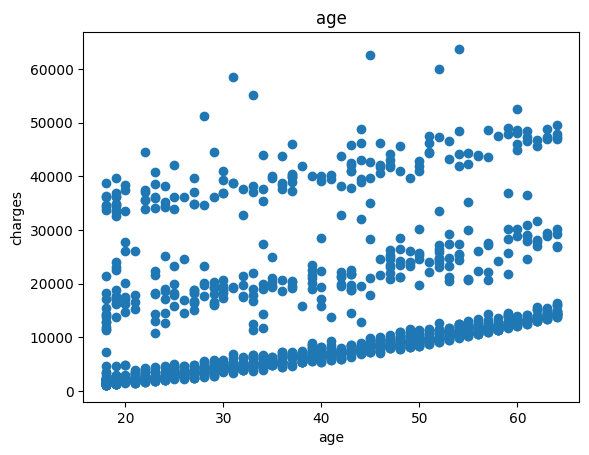

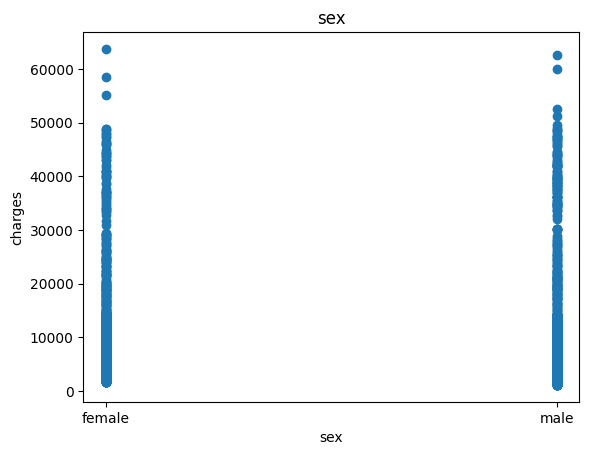

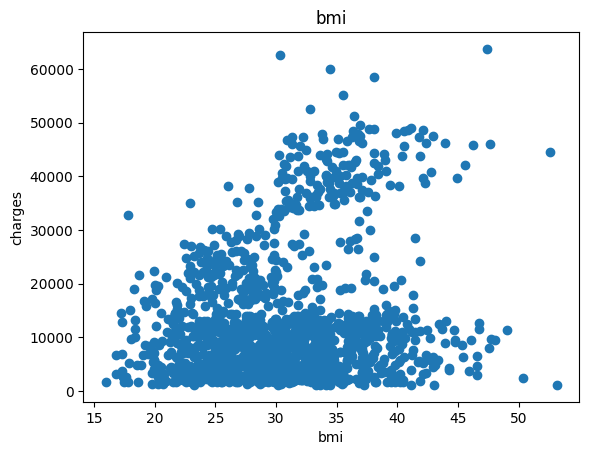

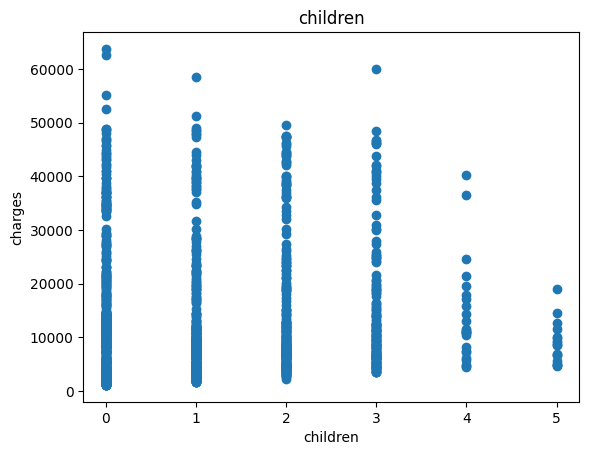

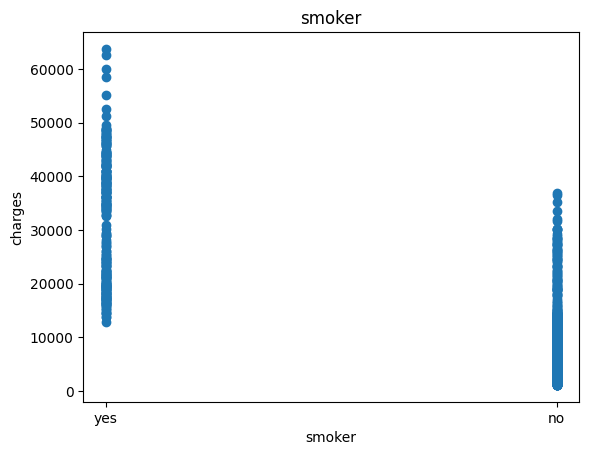

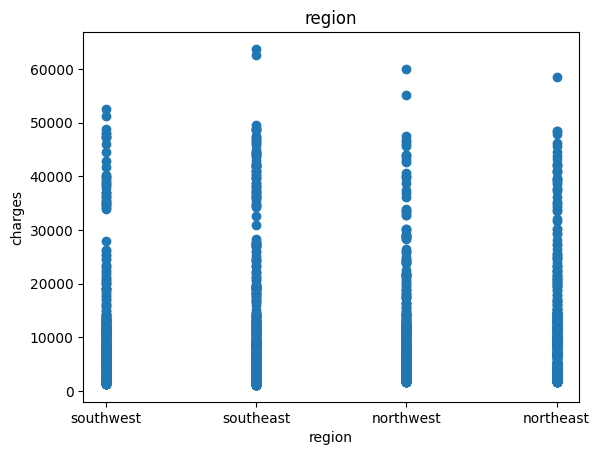

In [8]:
for label in cost.columns[:-1]:
  plt.scatter(cost[label], cost["charges"])
  plt.title(label)
  plt.ylabel("charges")
  plt.xlabel(label)
  plt.show()

### *Convert numeric*

In [9]:
counts1 = cost["sex"].value_counts()
counts2 = cost["smoker"].value_counts()
counts3 = cost["region"].value_counts()
print(counts1)
print(counts2)
print(counts3)

sex
male      675
female    662
Name: count, dtype: int64
smoker
no     1063
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64


In [10]:
def numeric (df):

  df = pd.get_dummies(df, columns=['sex', 'smoker'])
  # Initialize BinaryEncoder
  encoder = BinaryEncoder(cols=['region'])
  df = encoder.fit_transform(df)

  return df

In [11]:
cost = numeric(cost)

In [17]:
# take corrulation that figure out the efects of each column on levelstress
corr = cost.corr()
corr["charges"].sort_values(ascending=False)

,charges
charges,1.000000
smoker_yes,0.787234
age,0.298308
bmi,0.198401
age/bmi,0.171372
children,0.067389
sex_male,0.058044
region_1,0.032355
region_0,0.005945
sex_female,-0.058044


In [14]:
corr_matrix = cost.corr()

fig = go.Figure(data=go.Heatmap(z=corr_matrix.values,
                                x=corr_matrix.columns,
                                y=corr_matrix.columns,
                                colorscale='Viridis'))
fig.update_layout(title='Correlation Matrix')
fig.show()

In [15]:
def add (ad):

  ad["age/bmi"] = ad["age"]/ad["bmi"]
  # ad["bmi/region_1"] = ad["bmi"]/ad["region_1"]
  # ad["sex_female/smoker_no"] = ad["sex_female"]/ad["smoker_no"]

  return ad

In [16]:
cost = add(cost)

# *Outliers*

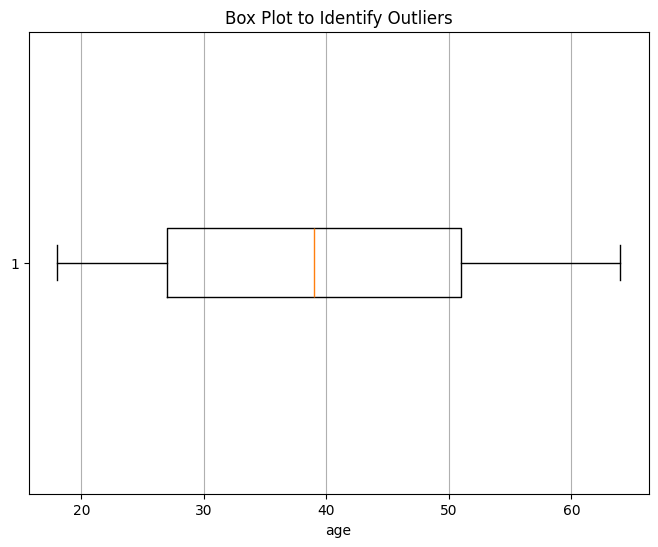

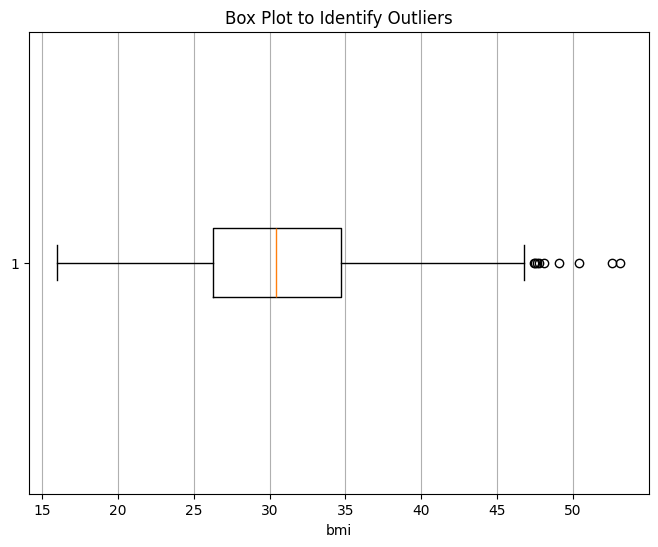

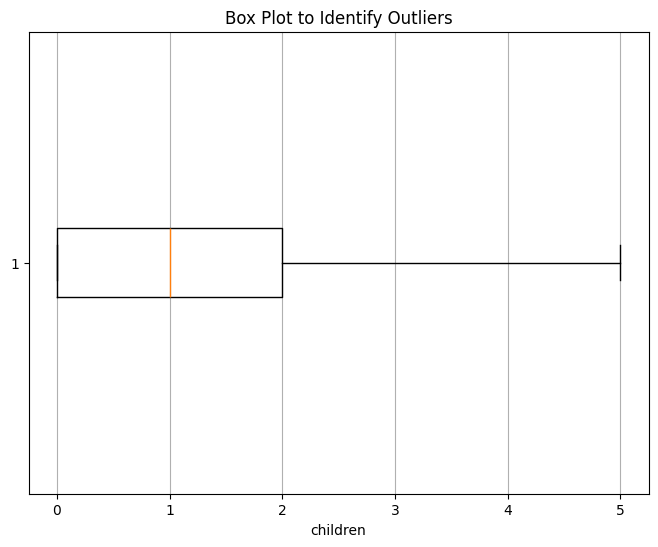

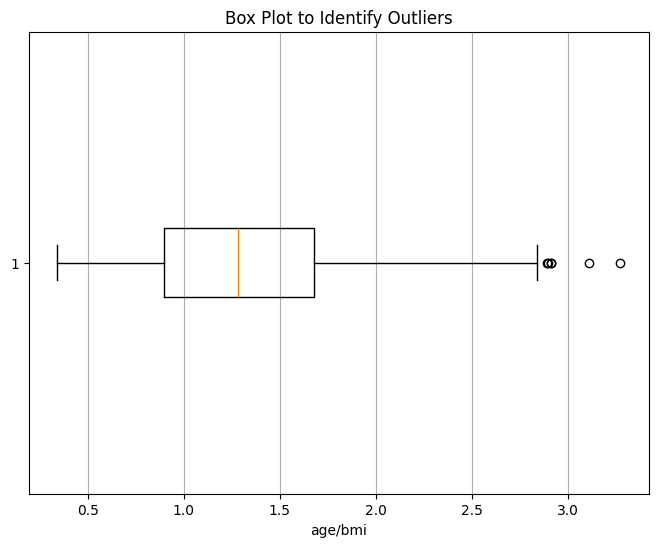

In [18]:
col = ["age","bmi","children","age/bmi"]

for i in col:

  plt.figure(figsize=(8, 6))
  plt.boxplot(cost[i], vert=False)
  plt.title('Box Plot to Identify Outliers')
  plt.xlabel(i)
  plt.grid(axis='x')
  plt.show()

In [19]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
col = ["age","bmi","children","age/bmi"]

for i in col:
  Q1 = cost[i].quantile(0.25)
  Q3 = cost[i].quantile(0.75)
  IQR = Q3 - Q1

  # Identify outliers
  outliers = cost[(cost[i] < (Q1 - 1.5 * IQR)) | (cost[i] > (Q3 + 1.5 * IQR))]

  # print("\nOutlier Rows using IQR:")
  # print(outliers)
  #print(outliers.sum())
  # Count the number of outliers
  num_outliers = outliers.shape[0]

  print("Number of outliers using IQR:", num_outliers)

Number of outliers using IQR: 0
Number of outliers using IQR: 9
Number of outliers using IQR: 0
Number of outliers using IQR: 6


## *we can ignore the number of outliers*
## because Their number is very *low*

### *check gaussian*
if Skewness close to 0
and Kurtosis close to 3

In [21]:
# Skewness and Kurtosis
col = ["age","bmi","children","age/bmi"]

for i in col:

  skewness = stats.skew(cost[i])
  kurtosis = stats.kurtosis(cost[i])
  print("Skewness: %.3f, Kurtosis: %.3f" % (skewness, kurtosis))

Skewness: 0.055, Kurtosis: -1.244
Skewness: 0.284, Kurtosis: -0.057
Skewness: 0.936, Kurtosis: 0.196
Skewness: 0.481, Kurtosis: -0.220


In [22]:
train, val, test = np.split(cost.sample(frac=1), [int(0.6*len(cost)), int(0.8*len(cost))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning:

'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.



In [23]:
def separate (xy):
  x = xy.drop('charges', axis=1)
  y =xy['charges']

  return x, y

In [24]:
x_train, y_train = separate(train)
x_test, y_test = separate(test)
x_val, y_val = separate(val)

# ***ML Models***

# *LinearRegression*

In [28]:
model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

# Step 6: Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 35705199.924396746
R-squared: 0.7441251701699949


# *GradientBoostingRegressor*

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the Gradient Boosting Regressor with default parameters
gbr = GradientBoostingRegressor(n_estimators=110, learning_rate=0.04, max_depth=3, random_state=42)

# Train the model
gbr.fit(x_train, y_train)

# Predict on test data
y_pred = gbr.predict(x_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 18425429.032093126
R-squared: 0.8679575096032368


## *check for finding best hyperparameters*

In [27]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Grid search
grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                           param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

grid_search.fit(x_train, y_train)
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


# *Naive Nayes*

In [29]:
from sklearn.linear_model import BayesianRidge

model = BayesianRidge()
model.fit(x_train, y_train)

# Predictions
y_pred = model.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Display a few predictions
print("Predicted values:", y_pred[:5])
print("Actual values:", y_test[:5])
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 35639194.30959982
Predicted values: [13106.55991258 30162.40693615   840.04656098 26678.56338607
 12786.31627887]
Actual values: 532     12925.88600
982     19199.94400
1292     1515.34490
1252    16232.84700
317     10435.06525
Name: charges, dtype: float64
Mean Squared Error: 35639194.30959982
R-squared: 0.7445981874192962


# *RandomForestRegressor*

In [30]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42, )

# Train the model
model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)


Mean Squared Error: 22429932.59761344
Root Mean Squared Error: 4736.024978567305
R^2 Score: 0.8392599621717483


# ***Neural network***

In [31]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [32]:
x_train.shape

(802, 11)

In [33]:
# all_normalizer = tf.keras.layers.Normalization(input_shape=(11,), axis=-1)
# all_normalizer.adapt(x_train)

nn_model = tf.keras.Sequential([
    # all_normalizer,
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')


In [34]:
history = nn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100
)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 323428544.0000 - val_loss: 295256160.0000
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 335279040.0000 - val_loss: 294255200.0000
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 321330144.0000 - val_loss: 292228736.0000
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 326523552.0000 - val_loss: 288480928.0000
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 344467712.0000 - val_loss: 282092416.0000
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 284413344.0000 - val_loss: 272531968.0000
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 301488480.0000 - val_loss: 259070224.0000
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 281454240.0000 - val_loss: 241866704.0000
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 277521440.0000 - val_loss: 221765776.0000
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 226180384.0000 - val_loss: 2004

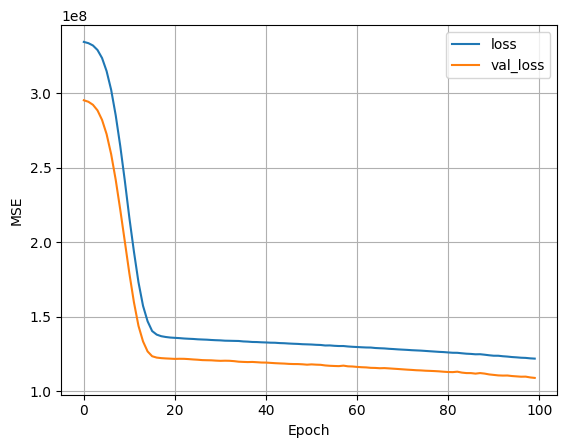

In [35]:
plot_loss(history)

In [36]:
# calculate the MSE for nn
y_pred_nn = nn_model.predict(x_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [37]:
mse = nn_model.evaluate(x_test, y_test)
print(f'MSE: {mse:.2f}')
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_nn)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_nn)

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100789688.0000
MSE: 107501984.00
Mean Squared Error: 107501977.96657953
Root Mean Squared Error: 10368.316062243643
R^2 Score: 0.22960660136809918


## *so GradientBoostingRegressor with high performance is the best model for this project*